In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [2]:
import cv2
#Converting the rgb data to gray scale
X_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
X_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])

X_train.shape

(50000, 32, 32)

In [3]:
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


In [5]:
!pip install validclust

In [6]:
from sklearn.metrics import pairwise_distances
from validclust import dunn
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist 

def find_kmeans(iterations, random_data = []):
  print('-----------------------------------------')    

  #To differentaite between single call with optimal random points and iterative call
  if (len(random_data) != 0):
    random_points = random_data
  else:
    random_points = np.random.choice(len(X_test), 10, replace= False)
  

  X_centroids = X_test[random_points, :]

  distances = np.empty((X_test.shape[0], X_centroids.shape[0]), dtype=np.double)

  #shape is (10000 , 10) - This is for all the data points we obtain 10 distances
  distances = cdist(X_test, X_centroids ,'euclidean')
  
  # this returns the index of minimum value of row passed for all the 10 distances
  # of each data point
  points = np.array([np.argmin(i) for i in distances])

  print(random_points)

  for _ in range(iterations): 
      centroids = []

      for i in range(10):
          #Updating Centroids by taking mean of Cluster it belongs to
          cluster_array = []
          for data in range(len(X_test)):
            if points[data] == i:
              cluster_array.append(X_test[data])

          temp_centroids = np.mean(cluster_array,axis=0) 
          
          centroids.append(temp_centroids)

      centroids = np.asarray(centroids)

      distances = cdist(X_test, centroids ,'euclidean')
      
      points = np.array([np.argmin(i) for i in distances])

  sil_score = silhouette_score(X_test, points)
  print('Silhoutte score: ',sil_score)
  dist = pairwise_distances(X_test)
  dun_score = dunn(dist,points)
  print('Dunn score: ',dun_score)

  return points

In [7]:
for i in range (0,10):
  find_kmeans(50)

-----------------------------------------
[5535 9316 8308 1713 4558 4735 2184 3441 3102  389]
Silhoutte score:  0.053549442753942765
Dunn score:  0.09027953916129534
-----------------------------------------
[6047 9482 5572  283 8578 4778 8082 6924 9538 9809]
Silhoutte score:  0.05736183119836066
Dunn score:  0.09027953916129534
-----------------------------------------
[ 735 6342 7471 9673 1396 6147 4246 2716 4051 1093]
Silhoutte score:  0.06294591562907485
Dunn score:  0.08665430985693591
-----------------------------------------
[7189 8367 9101 8697 5293 9948  796 5937 3465 2600]
Silhoutte score:  0.052815626236913236
Dunn score:  0.08885103245063727
-----------------------------------------
[4044 1467  208 5408 3737 8877 6278 9270 9012 6165]
Silhoutte score:  0.06180850044155943
Dunn score:  0.08665430985693591
-----------------------------------------
[ 946  111 2088 1413 3985 6305  544  604 2613 1613]
Silhoutte score:  0.05409436706096824
Dunn score:  0.09027953916129534
--------

In [8]:
Target_Labels = find_kmeans(50,[865,8519,5137,2305,3653,4248,6965,4310,2482,305])

-----------------------------------------
[865, 8519, 5137, 2305, 3653, 4248, 6965, 4310, 2482, 305]
Silhoutte score:  0.05764828003943545
Dunn score:  0.09283983112375284


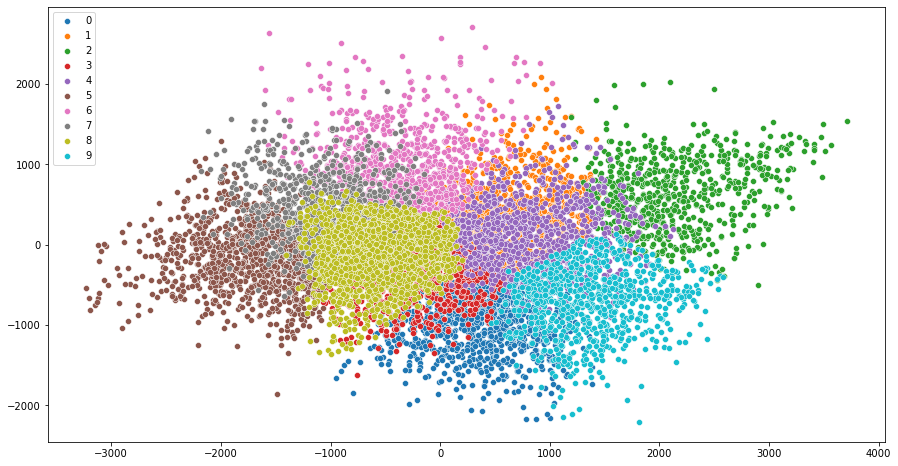

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(2)
X_test_transformed = pca.fit_transform(X_test)

Unique_Points = np.unique(Target_Labels)

plt.figure(figsize=(15,8))
for i in Unique_Points:
    sns.scatterplot(data=X_test_transformed, x=X_test_transformed[Target_Labels==i][:,0],y=X_test_transformed[Target_Labels==i][:,1],palette='cool')
    #plt.scatter(X_test_transformed[Target_Labels == i , 0] , X_test_transformed[Target_Labels == i , 1])
    
plt.legend(Unique_Points)
plt.show()

In [243]:
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import pairwise_distances
from validclust import dunn
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist 

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train / 255
X_test = X_test / 255

In [244]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] * X_train.shape[2] * X_train.shape[3])

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

X_train.shape

(50000, 3072)

In [245]:
def autoEncoder(epochs_input, batchsize_input):
    print('------------------------------')
    print('Batch Size = %ed', batchsize_input)
    print('Epochs = %d', epochs_input)
    
    input = keras.Input(shape=(3072))

    encoding = keras.layers.Dense(1024, activation="relu",activity_regularizer=regularizers.l1(10e-7))(input)
    #encoding = keras.layers.Dense(768, activation='relu')(encoding)
    encoding = keras.layers.Dense(27, activation='relu')(encoding)

    #decoded = keras.layers.Dense(768, activation='relu')(encoding)
    decoded = keras.layers.Dense(1024, activation='relu')(encoding)
    decoding = keras.layers.Dense(3072, activation="sigmoid")(decoded)

    auto_encoder = keras.Model(input, decoding)

    encoding_model = keras.Model(input, encoding, name="encoder")

    auto_encoder.compile(optimizer='adam', loss = 'binary_crossentropy')
    history = auto_encoder.fit(X_train, X_train,epochs=epochs_input,batch_size=batchsize_input, validation_data = (X_test, X_test))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'], loc='lower right')
    #plt.title('Loss comparison - Training and Validation - Batch

    plt.show()
    
    

------------------------------
Batch Size = %ed 16
Epochs = %d 5
Epoch 1/5
3125/3125 [==============================] - 87s 28ms/step - loss: 0.6310 - val_loss: 0.6276
Epoch 2/5
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6257 - val_loss: 0.6233
Epoch 3/5
3125/3125 [==============================] - 75s 24ms/step - loss: 0.6224 - val_loss: 0.6238
Epoch 4/5
3125/3125 [==============================] - 78s 25ms/step - loss: 0.6223 - val_loss: 0.6221
Epoch 5/5
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6222 - val_loss: 0.6221


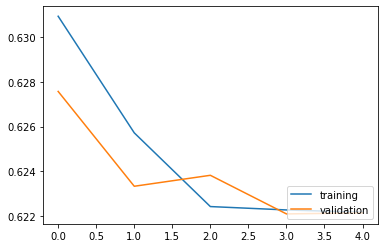

------------------------------
Batch Size = %ed 32
Epochs = %d 5
Epoch 1/5
1563/1563 [==============================] - 46s 29ms/step - loss: 0.6413 - val_loss: 0.6284
Epoch 2/5
1563/1563 [==============================] - 50s 32ms/step - loss: 0.6273 - val_loss: 0.6275
Epoch 3/5
1563/1563 [==============================] - 53s 34ms/step - loss: 0.6238 - val_loss: 0.6231
Epoch 4/5
1563/1563 [==============================] - 46s 30ms/step - loss: 0.6218 - val_loss: 0.6220
Epoch 5/5
1563/1563 [==============================] - 47s 30ms/step - loss: 0.6216 - val_loss: 0.6223


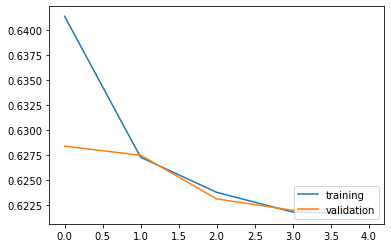

------------------------------
Batch Size = %ed 64
Epochs = %d 5
Epoch 1/5
782/782 [==============================] - 28s 36ms/step - loss: 0.6453 - val_loss: 0.6394
Epoch 2/5
782/782 [==============================] - 28s 36ms/step - loss: 0.6315 - val_loss: 0.6277
Epoch 3/5
782/782 [==============================] - 29s 37ms/step - loss: 0.6272 - val_loss: 0.6272
Epoch 4/5
782/782 [==============================] - 31s 39ms/step - loss: 0.6268 - val_loss: 0.6273
Epoch 5/5
782/782 [==============================] - 26s 33ms/step - loss: 0.6266 - val_loss: 0.6283


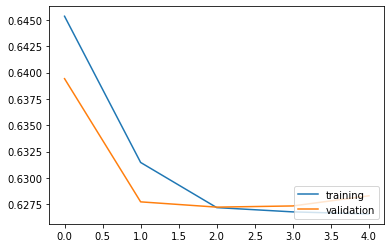

------------------------------
Batch Size = %ed 16
Epochs = %d 10
Epoch 1/10
3125/3125 [==============================] - 78s 25ms/step - loss: 0.6613 - val_loss: 0.6508
Epoch 2/10
3125/3125 [==============================] - 78s 25ms/step - loss: 0.6508 - val_loss: 0.6514
Epoch 3/10
3125/3125 [==============================] - 77s 25ms/step - loss: 0.6508 - val_loss: 0.6515
Epoch 4/10
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6508 - val_loss: 0.6506
Epoch 5/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.6508 - val_loss: 0.6514
Epoch 6/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.6507 - val_loss: 0.6508
Epoch 7/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.6507 - val_loss: 0.6528
Epoch 8/10
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6507 - val_loss: 0.6525
Epoch 9/10
3125/3125 [==============================] - 80s 26ms/step - loss: 0.6506 - val_loss: 0.650

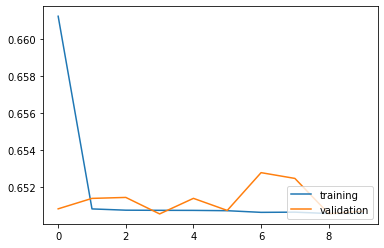

------------------------------
Batch Size = %ed 32
Epochs = %d 10
Epoch 1/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.6372 - val_loss: 0.6278
Epoch 2/10
1563/1563 [==============================] - 48s 31ms/step - loss: 0.6239 - val_loss: 0.6226
Epoch 3/10
1563/1563 [==============================] - 49s 32ms/step - loss: 0.6193 - val_loss: 0.6177
Epoch 4/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6171 - val_loss: 0.6175
Epoch 5/10
1563/1563 [==============================] - 49s 32ms/step - loss: 0.6168 - val_loss: 0.6171
Epoch 6/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6166 - val_loss: 0.6189
Epoch 7/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.6165 - val_loss: 0.6175
Epoch 8/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.6165 - val_loss: 0.6168
Epoch 9/10
1563/1563 [==============================] - 54s 34ms/step - loss: 0.6164 - val_loss: 0.617

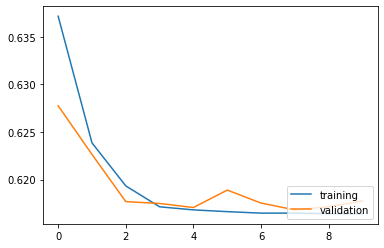

------------------------------
Batch Size = %ed 64
Epochs = %d 10
Epoch 1/10
782/782 [==============================] - 30s 38ms/step - loss: 0.6375 - val_loss: 0.6253
Epoch 2/10
782/782 [==============================] - 29s 37ms/step - loss: 0.6222 - val_loss: 0.6193
Epoch 3/10
782/782 [==============================] - 30s 38ms/step - loss: 0.6164 - val_loss: 0.6150
Epoch 4/10
782/782 [==============================] - 30s 38ms/step - loss: 0.6138 - val_loss: 0.6139
Epoch 5/10
782/782 [==============================] - 29s 38ms/step - loss: 0.6132 - val_loss: 0.6137
Epoch 6/10
782/782 [==============================] - 28s 35ms/step - loss: 0.6129 - val_loss: 0.6177
Epoch 7/10
782/782 [==============================] - 28s 35ms/step - loss: 0.6127 - val_loss: 0.6132
Epoch 8/10
782/782 [==============================] - 28s 36ms/step - loss: 0.6125 - val_loss: 0.6130
Epoch 9/10
782/782 [==============================] - 28s 35ms/step - loss: 0.6124 - val_loss: 0.6141
Epoch 10/10
782/

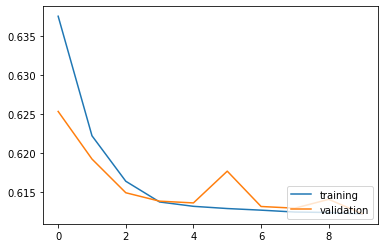

------------------------------
Batch Size = %ed 16
Epochs = %d 15
Epoch 1/15
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6323 - val_loss: 0.6278
Epoch 2/15
3125/3125 [==============================] - 83s 27ms/step - loss: 0.6245 - val_loss: 0.6231
Epoch 3/15
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6224 - val_loss: 0.6230
Epoch 4/15
3125/3125 [==============================] - 83s 26ms/step - loss: 0.6222 - val_loss: 0.6229
Epoch 5/15
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6221 - val_loss: 0.6223
Epoch 6/15
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6221 - val_loss: 0.6225
Epoch 7/15
3125/3125 [==============================] - 86s 28ms/step - loss: 0.6220 - val_loss: 0.6225
Epoch 8/15
3125/3125 [==============================] - 82s 26ms/step - loss: 0.6221 - val_loss: 0.6264
Epoch 9/15
3125/3125 [==============================] - 81s 26ms/step - loss: 0.6220 - val_loss: 0.622

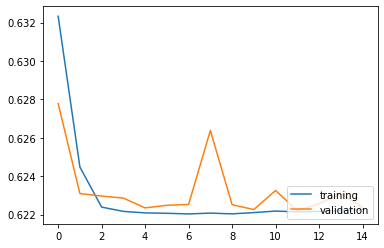

------------------------------
Batch Size = %ed 32
Epochs = %d 15
Epoch 1/15
1563/1563 [==============================] - 49s 31ms/step - loss: 0.6405 - val_loss: 0.6377
Epoch 2/15
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6360 - val_loss: 0.6366
Epoch 3/15
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6301 - val_loss: 0.6274
Epoch 4/15
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6270 - val_loss: 0.6277
Epoch 5/15
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6267 - val_loss: 0.6270
Epoch 6/15
1563/1563 [==============================] - 51s 32ms/step - loss: 0.6266 - val_loss: 0.6274
Epoch 7/15
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6265 - val_loss: 0.6271
Epoch 8/15
1563/1563 [==============================] - 1214s 777ms/step - loss: 0.6265 - val_loss: 0.6286
Epoch 9/15
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6265 - val_loss: 0.

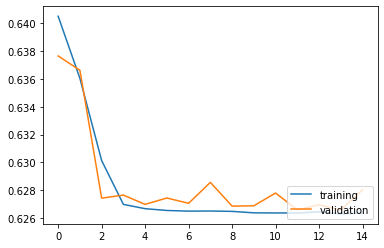

------------------------------
Batch Size = %ed 64
Epochs = %d 15
Epoch 1/15
782/782 [==============================] - 27s 34ms/step - loss: 0.6477 - val_loss: 0.6376
Epoch 2/15
782/782 [==============================] - 26s 34ms/step - loss: 0.6362 - val_loss: 0.6377
Epoch 3/15
782/782 [==============================] - 27s 34ms/step - loss: 0.6358 - val_loss: 0.6364
Epoch 4/15
782/782 [==============================] - 27s 34ms/step - loss: 0.6356 - val_loss: 0.6362
Epoch 5/15
782/782 [==============================] - 29s 37ms/step - loss: 0.6355 - val_loss: 0.6362
Epoch 6/15
782/782 [==============================] - 28s 36ms/step - loss: 0.6355 - val_loss: 0.6369
Epoch 7/15
782/782 [==============================] - 30s 38ms/step - loss: 0.6354 - val_loss: 0.6360
Epoch 8/15
782/782 [==============================] - 30s 38ms/step - loss: 0.6297 - val_loss: 0.6276
Epoch 9/15
782/782 [==============================] - 30s 39ms/step - loss: 0.6267 - val_loss: 0.6275
Epoch 10/15
782/

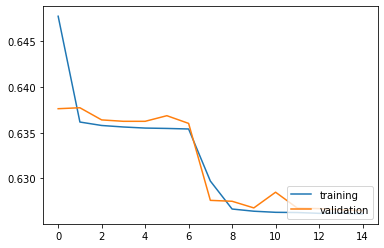

In [246]:
epochs = [5,10,15]
batches = [16,32,64]

for epoch in epochs:
    for batch in batches:
        autoEncoder(epoch, batch)

Epoch 1/10
782/782 [==============================] - 28s 35ms/step - loss: 0.6295 - val_loss: 0.6187
Epoch 2/10
782/782 [==============================] - 28s 35ms/step - loss: 0.6151 - val_loss: 0.6135
Epoch 3/10
782/782 [==============================] - 26s 34ms/step - loss: 0.6116 - val_loss: 0.6119
Epoch 4/10
782/782 [==============================] - 25s 32ms/step - loss: 0.6108 - val_loss: 0.6114
Epoch 5/10
782/782 [==============================] - 27s 34ms/step - loss: 0.6077 - val_loss: 0.6056
Epoch 6/10
782/782 [==============================] - 27s 34ms/step - loss: 0.6042 - val_loss: 0.6047
Epoch 7/10
782/782 [==============================] - 26s 34ms/step - loss: 0.6036 - val_loss: 0.6046
Epoch 8/10
782/782 [==============================] - 26s 34ms/step - loss: 0.6032 - val_loss: 0.6042
Epoch 9/10
782/782 [==============================] - 27s 35ms/step - loss: 0.6029 - val_loss: 0.6040
Epoch 10/10
782/782 [==============================] - 28s 36ms/step - loss: 0.601

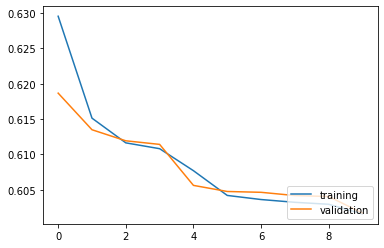

In [252]:

input = keras.Input(shape=(3072))

encoding = keras.layers.Dense(1024, activation="relu",activity_regularizer=regularizers.l1(10e-7))(input)
encoding = keras.layers.Dense(27, activation='relu')(encoding)

decoded = keras.layers.Dense(1024, activation='relu')(encoding)
decoding = keras.layers.Dense(3072, activation="sigmoid")(decoded)

auto_encoder = keras.Model(input, decoding)

encoding_model = keras.Model(input, encoding, name="encoder")

auto_encoder.compile(optimizer='adam', loss = 'binary_crossentropy')
history = auto_encoder.fit(X_train, X_train,epochs=10,batch_size=64, validation_data = (X_test, X_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='lower right')
#plt.title('Loss comparison - Training and Validation - Batch size=%d, epochs=%d', batchsize_input, epochs_input)

plt.show()

In [253]:

encodingPrediction = encoding_model.predict(X_train)
decoded_imgs = auto_encoder.predict(X_train)

In [254]:
decoded_imgs.shape

(50000, 3072)

In [255]:
from sklearn.cluster import KMeans

points = KMeans(n_clusters=10, random_state=11,max_iter=45).fit_predict(encodingPrediction)


In [256]:
sil_score = silhouette_score(encodingPrediction, points)
print('Silhoutte score: ',sil_score)

Silhoutte score:  0.10802264


In [80]:
X_train.shape

(50000, 3072)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

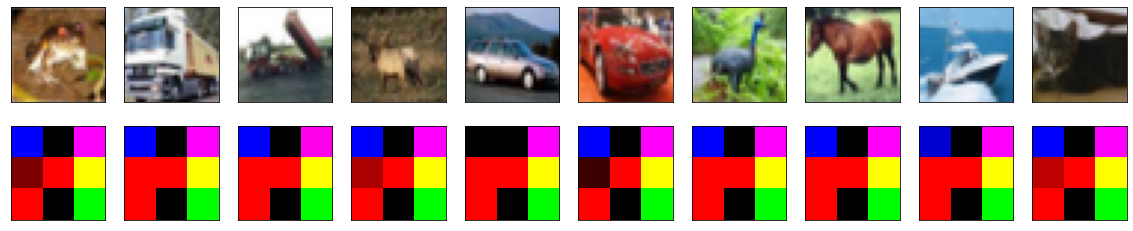

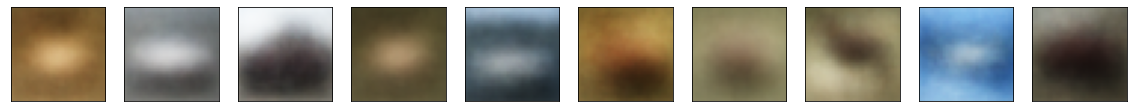

In [257]:

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encodingPrediction[i].reshape(3,3,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.figure(figsize=(20, 4))
# Display decoding
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()